In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import io
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler, SubsetRandomSampler

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model

# Transformers
from transformers import (
    AdamW, 
    BertTokenizer, 
    BertForSequenceClassification, 
    BertModel, 
    AutoTokenizer, 
    AutoModelForMaskedLM, 
    AutoModel
)

# PyTorch Pretrained BERT 
from pytorch_pretrained_bert import BertTokenizer as PTBertTokenizer, BertForSequenceClassification

# Scikit-learn
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    roc_curve, 
    auc, 
    confusion_matrix, 
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm, trange

os.environ['TRANSFORMERS_CACHE'] = '/mnt/raid1/eliza/TEXT_MINING/trans_cache'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
cache = '/mnt/raid1/eliza/TEXT_MINING/trans_cache'
models_path = 'models/fine_tuning/Scibert/'
model_name = 'allenai/scibert_scivocab_uncased'

2025-03-18 11:52:05.686475: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 11:52:05.728577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 11:52:05.728617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 11:52:05.730015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 11:52:05.737304: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Linear top layer

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm import trange

# Hyperparameters
MAX_LEN = 128
BATCH_SIZE = 64  
device = torch.device("cpu")  
BEST_FOLD = None  
RANDOM_SEED = 42  
epochs = 20
num_folds = 5
BEST_MODEL_PATH = models_path + '/linear_ft.pt'  

torch.manual_seed(RANDOM_SEED)

# Load tokenizer and model

tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir=cache, do_lower_case=True, truncation=True)

model = BertForSequenceClassification.from_pretrained(model_name, cache_dir=cache,
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)

# Load data
train_set = pd.read_csv('data/manual_curation/train.csv')
test_set = pd.read_csv('data/manual_curation/test.csv')

train_labels = train_set["LABEL"].values
validation_labels = test_set["LABEL"].values

train_sents = train_set["SENTENCE"]
validation_sents = test_set["SENTENCE"]

# Tokenize input data
train_encodings = tokenizer(train_sents.tolist(), truncation=True, padding=True, max_length=MAX_LEN)
validation_encodings = tokenizer(validation_sents.tolist(), truncation=True, padding=True, max_length=MAX_LEN)

# Create tensors for train and validation sets
input_ids_train = torch.tensor(train_encodings['input_ids'])
attention_mask_train = torch.tensor(train_encodings['attention_mask'])
input_ids_val = torch.tensor(validation_encodings['input_ids'])
attention_mask_val = torch.tensor(validation_encodings['attention_mask'])
train_labels = torch.tensor(train_labels).long()
validation_labels = torch.tensor(validation_labels).long()

# Prepare datasets
train_dataset = TensorDataset(input_ids_train, attention_mask_train, train_labels)
validation_dataset = TensorDataset(input_ids_val, attention_mask_val, validation_labels)

# Optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)  

# Cross-validation setup
cross_validator = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_SEED)

# Training loop with tracking of the best model based on validation loss
best_fold_eval_losses = []  # To store losses for the best fold
best_fold_train_losses = []  # To store train losses for the best fold
best_model_eval_loss = float('inf')  # Track the overall best model evaluation loss
accuracy_scores = []
classification_reports = []
folds = []
epochs_list = []
train_losses = []
eval_losses = []

for fold, (train_indices, val_indices) in enumerate(cross_validator.split(train_dataset)):
    print(f"\nStarting Fold {fold + 1}/{num_folds}...")

    # Early stopping parameters
    patience = 3
    early_stopping_counter = 0
    best_eval_loss_for_fold = float('inf')

    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

    # Initialize per-fold tracking
    fold_train_losses = []
    fold_eval_losses = []

    for epoch in trange(epochs, desc=f"Fold {fold + 1}/{num_folds}"):
        model.train()
        tr_loss = 0

        # Training loop
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            tr_loss += loss.item()

        tr_loss /= len(train_loader)
        fold_train_losses.append(tr_loss)

        # Validation loop
        model.eval()
        eval_loss = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                eval_loss += outputs.loss.item()

                logits = outputs.logits
                _, predicted_labels = torch.max(logits, dim=1)
                val_predictions.extend(predicted_labels.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        eval_loss /= len(val_loader)
        fold_eval_losses.append(eval_loss)

        # Early stopping condition
        if eval_loss < best_eval_loss_for_fold:
            best_eval_loss_for_fold = eval_loss
            early_stopping_counter = 0
            # Save the model if it's the best for this fold
            if eval_loss < best_model_eval_loss:
                best_model_eval_loss = eval_loss
                BEST_FOLD = fold + 1
                torch.save(model.state_dict(), BEST_MODEL_PATH)
                print(f"Best model updated from Fold {fold + 1}, Epoch {epoch + 1} with Validation Loss: {eval_loss:.4f}")

            # Save best fold losses
            if BEST_FOLD == fold + 1:
                best_fold_eval_losses = fold_eval_losses
                best_fold_train_losses = fold_train_losses
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping in fold {fold + 1} at epoch {epoch + 1}")
                break

        # Track accuracy for each fold
        accuracy = accuracy_score(val_true_labels, val_predictions)
        classification_report_str = classification_report(val_true_labels, val_predictions)

        accuracy_scores.append(accuracy)
        classification_reports.append(classification_report_str)
        folds.append(fold + 1)
        epochs_list.append(epoch + 1)
        train_losses.append(tr_loss)
        eval_losses.append(eval_loss)

print(f"The best model was from Fold {BEST_FOLD} with Validation Loss: {best_model_eval_loss:.4f}")

# Save loss information for all folds
losses_df = pd.DataFrame({
    'Fold': folds,
    'Epoch': epochs_list,
    'Train Loss': train_losses,
    'Eval Loss': eval_losses
})
losses_df.to_csv(models_path + '/losses_linear_all_folds.csv', index=False)

# Save losses only for the best fold
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_losses) + 1),
    'Train Loss': best_fold_train_losses,
    'Eval Loss': best_fold_eval_losses
})
best_fold_losses_df.to_csv(models_path + '/losses_linear_best_fold.csv', index=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting Fold 1/5...


Fold 1/5:   5%|█▋                               | 1/20 [02:58<56:29, 178.41s/it]

Best model updated from Fold 1, Epoch 1 with Validation Loss: 0.4273


Fold 1/5:  10%|███▎                             | 2/20 [05:52<52:49, 176.06s/it]

Best model updated from Fold 1, Epoch 2 with Validation Loss: 0.3318


Fold 1/5:  15%|████▉                            | 3/20 [08:41<48:54, 172.62s/it]

Best model updated from Fold 1, Epoch 3 with Validation Loss: 0.3193


Fold 1/5:  25%|████████▎                        | 5/20 [17:11<51:33, 206.26s/it]


Early stopping in fold 1 at epoch 6

Starting Fold 2/5...


Fold 2/5:  15%|████▋                          | 3/20 [11:18<1:04:04, 226.17s/it]


Early stopping in fold 2 at epoch 4

Starting Fold 3/5...


Fold 3/5:  15%|████▋                          | 3/20 [11:20<1:04:13, 226.68s/it]


Early stopping in fold 3 at epoch 4

Starting Fold 4/5...


Fold 4/5:  25%|████████▎                        | 5/20 [17:03<51:09, 204.64s/it]


Early stopping in fold 4 at epoch 6

Starting Fold 5/5...


Fold 5/5:  25%|████████▎                        | 5/20 [16:52<50:38, 202.55s/it]

Early stopping in fold 5 at epoch 6
The best model was from Fold 1 with Validation Loss: 0.3193


In [4]:
# for metrics in test set - Linear

In [5]:

model.eval()
val_predictions = []
val_true_labels = []
val_probs = []

with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = F.softmax(logits, dim=1)  # Apply softmax to logits to get probabilities
        _, predicted_labels = torch.max(logits, dim=1)
        val_predictions.extend(predicted_labels.cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())
        val_probs.append(probs[:, 1].cpu().numpy())  # Save probability of label=1 to val_probs list

val_probs_flat = [item for sublist in val_probs for item in sublist]   # Flatten the list

fpr1, tpr1, thresholds1 = roc_curve(val_true_labels, val_probs_flat)  # Calculate ROC Curve
roc_auc1 = auc(fpr1, tpr1)  # Calculate Area Under Curve (AUC)

# Compute the curve and the area
precision1, recall1, _ = precision_recall_curve(val_true_labels, val_probs_flat)
area1 = auc(recall1, precision1)

cm1 = confusion_matrix(val_true_labels, val_predictions)
tn, fp, fn, tp = cm1.ravel()
precision = tp / (tp + fp)
precision = round(precision, 3)
recall = tp / (tp + fn)
recall = round(recall, 3)
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy = round(accuracy, 3)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score = round(f1_score, 3)
specificity = tn / (tn+fp)
specificity = round(specificity, 3)

# Create a DataFrame for each algorithm
df1 = pd.DataFrame({
    'Algorithm': ['Linear'],
    'Precision': [precision],
    'Recall': [recall],
    'Specificity': [specificity],
    'Accuracy': [accuracy],
    'F1 Score': [f1_score]
})

# Print the scores DataFrame
print(df1)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0    Linear      0.837   0.941        0.708     0.851     0.886


In [6]:
# CNN layer

In [7]:
device = torch.device("cpu")
BEST_MODEL_PATH = models_path + '/cnn_ft.h5'  # Path to save the best model

# Set the random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Set the device (CPU or GPU)
device = torch.device("cpu")

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir=cache, do_lower_case=True, truncation=True)

# Load the Bert Model
bert_model = BertModel.from_pretrained(model_name, cache_dir=cache,
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
bert_model.to(device)

# Define CNN parameters
hidden_size = 768
num_classes = 2  
kernel_size = 3  
num_filters = 128 

class CustomModel_CNN(nn.Module):
    def __init__(self, bert_model, num_filters, num_classes):
        super(CustomModel_CNN, self).__init__()
        self.bert_model = bert_model
        self.conv1d = nn.Conv1d(in_channels=hidden_size, out_channels=num_filters, kernel_size=3)
        self.classifier = nn.Linear(num_filters, num_classes)  # Adjusted to match conv1d output size
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        hidden_state = hidden_state.permute(0, 2, 1)  # Shape: [batch_size, hidden_size, sequence_length]
        
        conv_output = self.conv1d(hidden_state)
        conv_output = F.relu(conv_output)
        pooled_output = F.max_pool1d(conv_output, conv_output.shape[2])
        flatten_output = pooled_output.view(pooled_output.shape[0], -1)
        logits = self.classifier(self.dropout(flatten_output))

        if labels is not None:
            loss = F.cross_entropy(logits.view(-1, num_classes), labels.view(-1))
            return loss, logits
        else:
            return logits

# Create an instance of the CustomModel
model = CustomModel_CNN(bert_model, num_filters, num_classes)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Cross-validator
cross_validator = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_SEED)

# Training loop with tracking of the best model based on validation loss
best_fold_eval_losses = []  # To store losses for the best fold
best_fold_train_losses = []  # To store train losses for the best fold
best_model_eval_loss = float('inf')  # Track the overall best model evaluation loss
accuracy_scores = []
classification_reports = []
folds = []
epochs_list = []
train_losses = []
eval_losses = []

for fold, (train_indices, val_indices) in enumerate(cross_validator.split(train_dataset)):
    print(f"\nStarting Fold {fold + 1}/{num_folds}...")

    # Early stopping parameters
    patience = 3
    early_stopping_counter = 0
    best_eval_loss_for_fold = float('inf')

    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
    # Create an instance of the CustomModel
    model = CustomModel_CNN(bert_model, num_filters, num_classes)

    # Set the model to the device
    model.to(device)

    # Define the optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)
    # Initialize per-fold tracking
    fold_train_losses = []
    fold_eval_losses = []

    for epoch in trange(epochs, desc=f"Fold {fold + 1}/{num_folds}"):
        model.train()
        tr_loss = 0

        # Training loop
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            loss.backward()
            optimizer.step()

            tr_loss += loss.item()

        tr_loss /= len(train_loader)
        fold_train_losses.append(tr_loss)

        # Validation loop
        model.eval()
        eval_loss = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                eval_loss += outputs[0]

                logits = model(input_ids, attention_mask=attention_mask)
                _, predicted_labels = torch.max(logits, dim=1)
                val_predictions.extend(predicted_labels.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        eval_loss /= len(val_loader)
        fold_eval_losses.append(eval_loss)

        # Early stopping condition
        if eval_loss < best_eval_loss_for_fold:
            best_eval_loss_for_fold = eval_loss
            early_stopping_counter = 0
            # Save the model if it's the best for this fold
            if eval_loss < best_model_eval_loss:
                best_model_eval_loss = eval_loss
                BEST_FOLD = fold + 1
                torch.save(model.state_dict(), BEST_MODEL_PATH)
                print(f"Best model updated from Fold {fold + 1}, Epoch {epoch + 1} with Validation Loss: {eval_loss:.4f}")

            # Save best fold losses
            if BEST_FOLD == fold + 1:
                best_fold_eval_losses = fold_eval_losses
                best_fold_train_losses = fold_train_losses
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping in fold {fold + 1} at epoch {epoch + 1}")
                break

        # Track accuracy for each fold
        accuracy = accuracy_score(val_true_labels, val_predictions)
        classification_report_str = classification_report(val_true_labels, val_predictions)

        accuracy_scores.append(accuracy)
        classification_reports.append(classification_report_str)
        folds.append(fold + 1)
        epochs_list.append(epoch + 1)
        train_losses.append(tr_loss)
        eval_losses.append(eval_loss)

print(f"The best model was from Fold {BEST_FOLD} with Validation Loss: {best_model_eval_loss:.4f}")

# Save loss information for all folds
losses_df = pd.DataFrame({
    'Fold': folds,
    'Epoch': epochs_list,
    'Train Loss': train_losses,
    'Eval Loss': eval_losses
})
losses_df.to_csv(models_path + '/losses_cnn_all_folds.csv', index=False)

# Save losses only for the best fold
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_losses) + 1),
    'Train Loss': best_fold_train_losses,
    'Eval Loss': best_fold_eval_losses
})
best_fold_losses_df.to_csv(models_path + '/losses_cnn_best_fold.csv', index=False)


Starting Fold 1/5...


Fold 1/5:   5%|█▋                               | 1/20 [02:59<56:58, 179.94s/it]

Best model updated from Fold 1, Epoch 1 with Validation Loss: 0.5059


Fold 1/5:  10%|███▎                             | 2/20 [05:59<53:49, 179.44s/it]

Best model updated from Fold 1, Epoch 2 with Validation Loss: 0.3555


Fold 1/5:  15%|████▉                            | 3/20 [08:58<50:50, 179.44s/it]

Best model updated from Fold 1, Epoch 3 with Validation Loss: 0.3117


Fold 1/5:  20%|██████▌                          | 4/20 [11:58<47:55, 179.71s/it]

Best model updated from Fold 1, Epoch 4 with Validation Loss: 0.2917


Fold 1/5:  30%|█████████▉                       | 6/20 [20:57<48:53, 209.53s/it]


Early stopping in fold 1 at epoch 7

Starting Fold 2/5...


Fold 2/5:  15%|████▋                          | 3/20 [11:58<1:07:48, 239.35s/it]


Early stopping in fold 2 at epoch 4

Starting Fold 3/5...


Fold 3/5:  25%|████████▎                        | 5/20 [18:04<54:14, 216.99s/it]


Early stopping in fold 3 at epoch 6

Starting Fold 4/5...


Fold 4/5:  15%|████▋                          | 3/20 [12:13<1:09:14, 244.41s/it]


Early stopping in fold 4 at epoch 4

Starting Fold 5/5...


Fold 5/5:  15%|████▋                          | 3/20 [12:12<1:09:11, 244.22s/it]

Early stopping in fold 5 at epoch 4
The best model was from Fold 1 with Validation Loss: 0.2917


In [8]:

model.eval()
val_predictions = []
val_true_labels = []
val_probs = []

with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids, attention_mask=attention_mask)
        #logits = outputs.logits

        probs = F.softmax(logits, dim=1)  # Apply softmax to logits to get probabilities
        _, predicted_labels = torch.max(logits, dim=1)
        val_predictions.extend(predicted_labels.cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())
        val_probs.append(probs[:, 1].cpu().numpy())  # Save probability of label=1 to val_probs list

val_probs_flat = [item for sublist in val_probs for item in sublist]   # Flatten the list

fpr2, tpr2, thresholds2 = roc_curve(val_true_labels, val_probs_flat)  # Calculate ROC Curve
roc_auc2 = auc(fpr2, tpr2)  # Calculate Area Under Curve (AUC)

# Compute the curve and the area
precision2, recall2, _ = precision_recall_curve(val_true_labels, val_probs_flat)
area2 = auc(recall2, precision2)

cm2 = confusion_matrix(val_true_labels, val_predictions)
tn, fp, fn, tp = cm2.ravel()
precision = tp / (tp + fp)
precision = round(precision, 3)
recall = tp / (tp + fn)
recall = round(recall, 3)
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy = round(accuracy, 3)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score = round(f1_score, 3)
specificity = tn / (tn+fp)
specificity = round(specificity, 3)

# Create a DataFrame for each algorithm
df2 = pd.DataFrame({
    'Algorithm': ['CNN'],
    'Precision': [precision],
    'Recall': [recall],
    'Specificity': [specificity],
    'Accuracy': [accuracy],
    'F1 Score': [f1_score]
})

# Print the scores DataFrame
print(df2)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0       CNN      0.902   0.918        0.842     0.888      0.91


In [9]:
# LSTM top layer

In [10]:

device = torch.device("cpu")
BEST_MODEL_PATH = models_path + '/lstm_ft.h5'  # Path to save the best model

# Set the random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Set the device (CPU or GPU)
device = torch.device("cpu")

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir=cache,
                                          do_lower_case=True, truncation=True)

# Load the model
bert_model = BertModel.from_pretrained(model_name, cache_dir=cache,
                                       num_labels=2,
                                       output_attentions=False,
                                       output_hidden_states=False)
bert_model.to(device)

# Define LSTM parameters
hidden_size = 768
num_classes = 2
hidden_dim = 128  # LSTM's hidden state's dimension

class CustomModel(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(CustomModel, self).__init__()
        self.bert_model = bert_model
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(hidden_size, hidden_dim, num_layers=1, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        hidden_state = self.dropout(hidden_state)
        _, (hidden, _) = self.lstm(hidden_state)
        
        logits = self.classifier(hidden[-1])  # use last LSTM output for classification

        if labels is not None:
            loss = F.cross_entropy(logits, labels.view(-1))
            return loss, logits
        else:
            return logits

# Create an instance of the CustomModel
model = CustomModel(bert_model, hidden_dim, num_classes)
model.to(device)

# Optimizer
param_optimizer = list(bert_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

# Create the cross-validator
cross_validator = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_SEED)

# Training loop with tracking of the best model based on validation loss
best_fold_eval_losses = []  # To store losses for the best fold
best_fold_train_losses = []  # To store train losses for the best fold
best_model_eval_loss = float('inf')  # Track the overall best model evaluation loss
accuracy_scores = []
classification_reports = []
folds = []
epochs_list = []
train_losses = []
eval_losses = []

for fold, (train_indices, val_indices) in enumerate(cross_validator.split(train_dataset)):
    print(f"\nStarting Fold {fold + 1}/{num_folds}...")

    # Early stopping parameters
    patience = 3
    early_stopping_counter = 0
    best_eval_loss_for_fold = float('inf')

    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
    # Create an instance of the CustomModel
    model = CustomModel(bert_model, hidden_dim, num_classes)

    # Set the model to the device
    model.to(device)

    # Define the optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)
    # Initialize per-fold tracking
    fold_train_losses = []
    fold_eval_losses = []

    for epoch in trange(epochs, desc=f"Fold {fold + 1}/{num_folds}"):
        model.train()
        tr_loss = 0

        # Training loop
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            loss.backward()
            optimizer.step()

            tr_loss += loss.item()

        tr_loss /= len(train_loader)
        fold_train_losses.append(tr_loss)

        # Validation loop
        model.eval()
        eval_loss = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                eval_loss += outputs[0]

                logits = model(input_ids, attention_mask=attention_mask)
                _, predicted_labels = torch.max(logits, dim=1)
                val_predictions.extend(predicted_labels.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        eval_loss /= len(val_loader)
        fold_eval_losses.append(eval_loss)

        # Early stopping condition
        if eval_loss < best_eval_loss_for_fold:
            best_eval_loss_for_fold = eval_loss
            early_stopping_counter = 0
            # Save the model if it's the best for this fold
            if eval_loss < best_model_eval_loss:
                best_model_eval_loss = eval_loss
                BEST_FOLD = fold + 1
                torch.save(model.state_dict(), BEST_MODEL_PATH)
                print(f"Best model updated from Fold {fold + 1}, Epoch {epoch + 1} with Validation Loss: {eval_loss:.4f}")

            # Save best fold losses
            if BEST_FOLD == fold + 1:
                best_fold_eval_losses = fold_eval_losses
                best_fold_train_losses = fold_train_losses
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping in fold {fold + 1} at epoch {epoch + 1}")
                break

        # Track accuracy for each fold
        accuracy = accuracy_score(val_true_labels, val_predictions)
        classification_report_str = classification_report(val_true_labels, val_predictions)

        accuracy_scores.append(accuracy)
        classification_reports.append(classification_report_str)
        folds.append(fold + 1)
        epochs_list.append(epoch + 1)
        train_losses.append(tr_loss)
        eval_losses.append(eval_loss)

print(f"The best model was from Fold {BEST_FOLD} with Validation Loss: {best_model_eval_loss:.4f}")

# Save loss information for all folds
losses_df = pd.DataFrame({
    'Fold': folds,
    'Epoch': epochs_list,
    'Train Loss': train_losses,
    'Eval Loss': eval_losses
})
losses_df.to_csv(models_path + '/losses_lstm_all_folds.csv', index=False)

# Save losses only for the best fold
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_losses) + 1),
    'Train Loss': best_fold_train_losses,
    'Eval Loss': best_fold_eval_losses
})
best_fold_losses_df.to_csv(models_path + '/losses_lstm_best_fold.csv', index=False)


Starting Fold 1/5...


Fold 1/5:   5%|█▌                             | 1/20 [03:10<1:00:15, 190.27s/it]

Best model updated from Fold 1, Epoch 1 with Validation Loss: 0.4946


Fold 1/5:  10%|███▎                             | 2/20 [06:20<57:07, 190.41s/it]

Best model updated from Fold 1, Epoch 2 with Validation Loss: 0.3930


Fold 1/5:  20%|██████▌                          | 4/20 [12:34<50:03, 187.72s/it]

Best model updated from Fold 1, Epoch 4 with Validation Loss: 0.3206


Fold 1/5:  30%|█████████▉                       | 6/20 [22:01<51:23, 220.25s/it]


Early stopping in fold 1 at epoch 7

Starting Fold 2/5...


Fold 2/5:  20%|██████▏                        | 4/20 [15:26<1:01:45, 231.62s/it]


Early stopping in fold 2 at epoch 5

Starting Fold 3/5...


Fold 3/5:  15%|████▋                          | 3/20 [12:30<1:10:50, 250.01s/it]


Early stopping in fold 3 at epoch 4

Starting Fold 4/5...


Fold 4/5:  30%|█████████▉                       | 6/20 [22:05<51:32, 220.91s/it]


Early stopping in fold 4 at epoch 7

Starting Fold 5/5...


Fold 5/5:  25%|████████▎                        | 5/20 [18:40<56:01, 224.13s/it]

Early stopping in fold 5 at epoch 6
The best model was from Fold 1 with Validation Loss: 0.3206


In [11]:
model.eval()
val_predictions = []
val_true_labels = []
val_probs = []

with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids, attention_mask=attention_mask) 

        probs = F.softmax(logits, dim=1)  
        _, predicted_labels = torch.max(logits, dim=1)
        val_predictions.extend(predicted_labels.cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())
        val_probs.append(probs[:, 1].cpu().numpy())  # Save probability of label=1 to val_probs list

val_probs_flat = [item for sublist in val_probs for item in sublist]   

fpr3, tpr3, thresholds3 = roc_curve(val_true_labels, val_probs_flat)  # Calculate ROC Curve
roc_auc3 = auc(fpr3, tpr3)  # Calculate Area Under Curve (AUC)

# Compute the curve and the area
precision3, recall3, _ = precision_recall_curve(val_true_labels, val_probs_flat)
area3 = auc(recall3, precision3)

cm3 = confusion_matrix(val_true_labels, val_predictions)
tn, fp, fn, tp = cm3.ravel()
precision = tp / (tp + fp)
precision = round(precision, 3)
recall = tp / (tp + fn)
recall = round(recall, 3)
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy = round(accuracy, 3)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score = round(f1_score, 3)
specificity = tn / (tn+fp)
specificity = round(specificity, 3)

# Create a DataFrame for each algorithm
df3 = pd.DataFrame({
    'Algorithm': ['LSTM'],
    'Precision': [precision],
    'Recall': [recall],
    'Specificity': [specificity],
    'Accuracy': [accuracy],
    'F1 Score': [f1_score]
})

# Print the scores DataFrame
print(df3)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0      LSTM      0.923   0.871        0.885     0.876     0.896


In [12]:
# ROC CURVES ON TEST SET

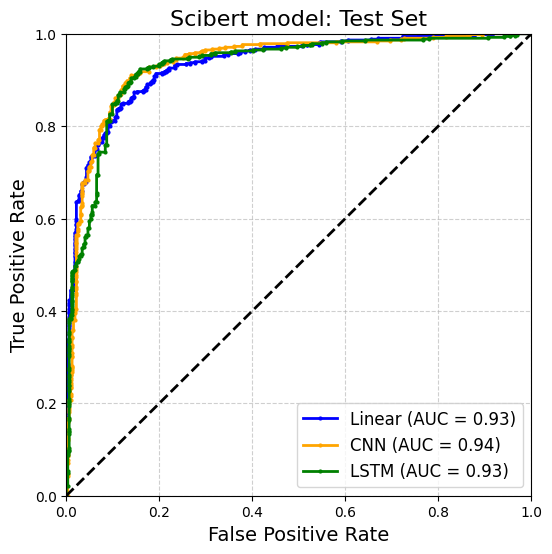

In [13]:

roc_aucs = [roc_auc1, roc_auc2, roc_auc3]
labels = ['Linear', 'CNN', 'LSTM']

plt.figure(figsize=(6, 6))  

plt.plot(fpr1, tpr1, lw=2, color='blue', label='{} (AUC = {:.2f})'.format('Linear', roc_auc1), marker='.', markersize=4)  
plt.plot(fpr2, tpr2, lw=2, color='orange', label='{} (AUC = {:.2f})'.format('CNN', roc_auc2), marker='.', markersize=4)  
plt.plot(fpr3, tpr3, lw=2, color='green', label='{} (AUC = {:.2f})'.format('LSTM', roc_auc3), marker='.', markersize=4)  

# Plot the diagonal line (random classifier) in black
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Scibert model: Test Set', fontsize=16)

plt.legend(loc='lower right', fontsize=12)

# Set axis limits
plt.xlim([0, 1])
plt.ylim([0, 1])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Save or show the plot
plt.savefig(models_path + 'roc_curves.png', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
# Precision Recall on Test 

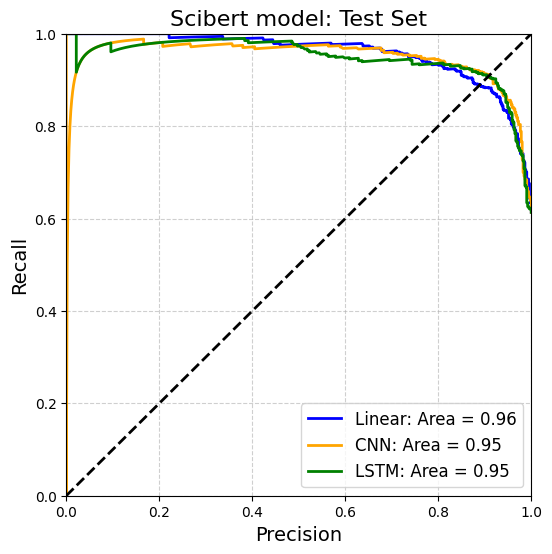

In [15]:
precisions = [precision1, precision2, precision3]
recalls = [recall1, recall2, recall3]
areas = [area1, area2, area3]

plt.figure(figsize=(6, 6))  

# Plot the precision-recall curves with the same colors and line styles as ROC curves
plt.plot(recall1, precision1, color='blue', label='Linear: Area = %0.2f' % area1, lw=2, markersize=4)
plt.plot(recall2, precision2, color='orange', label='CNN: Area = %0.2f' % area2, lw=2, markersize=4)
plt.plot(recall3, precision3, color='green', label='LSTM: Area = %0.2f' % area3, lw=2, markersize=4)

plt.legend(loc='lower right')

# Plot the diagonal line (random classifier) in black
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('Precision', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.title('Scibert model: Test Set', fontsize=16)

plt.legend(loc='lower right', fontsize=12)

# Set axis limits
plt.xlim([0, 1])
plt.ylim([0, 1])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Save or show the plot
plt.savefig(models_path + 'precision_recall.png', dpi=600, bbox_inches='tight')
plt.show()

In [16]:
# Evaluation sets

In [17]:
tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir= cache, do_lower_case=True,truncation=True)
model = BertForSequenceClassification.from_pretrained(model_name, cache_dir= cache,
                                            
                                                        num_labels= 2,
                                                        output_attentions=False,
                                                        output_hidden_states=False)
                                                    
model.load_state_dict(torch.load(models_path + '/linear_ft.pt'))
model.to(device)
model.eval()

df = pd.read_csv('data/manual_curation/eval.csv')  # Load the balanced dataset CSV
sentences = df["SENTENCE"]
labels = df["LABEL"].astype(int) 
MAX_LEN = 128
BATCH_SIZE = 64
device = torch.device("cpu")

tokenize_val = sentences.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
padded_val = np.array([i + [0]*(MAX_LEN-len(i)) for i in tokenize_val.values])

# We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input.

attention_mask_val = np.where(padded_val != 0, 1, 0)
input_ids_val = torch.tensor(padded_val)  
attention_mask_val = torch.tensor(attention_mask_val)
validation_labels = torch.tensor(labels)
validation_inputs = torch.tensor(input_ids_val)
validation_masks = torch.tensor(attention_mask_val)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

# training hyperparameters from within the stored model.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

all_logits = []
validation_labels = []

# Make predictions on validation data
all_predictions = []
validation_labels = []
with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, input_mask, label_ids = batch
        output = model(input_ids, input_mask)
        logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.tolist())
        validation_labels.extend(label_ids.tolist())
        all_logits.append(logits)

# Calculate probabilities
all_logits = torch.cat(all_logits, dim=0)
probs_linear = F.softmax(all_logits, dim=1).cpu().numpy()

# Calculate the confusion matrix.
cm1 = confusion_matrix(validation_labels, all_predictions)
fpr1, tpr1, thresholds = roc_curve(validation_labels, probs_linear[:, 1])  # Calculate ROC Curve
roc_auc1 = auc(fpr1, tpr1)  # Calculate Area Under Curve (AUC)
# Compute the curve and the area
precision1, recall1, _ = precision_recall_curve(validation_labels, probs_linear[:, 1])
area1 = auc(recall1, precision1)
# Print the confusion matrix.
print(cm1)
tn, fp, fn, tp = cm1.ravel()
precision = tp / (tp + fp)
precision = round(precision, 3)
recall = tp / (tp + fn)
recall = round(recall, 3)
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy = round(accuracy, 3)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score = round(f1_score, 3)
specificity = tn / (tn+fp)
specificity = round(specificity, 3)

# Create a DataFrame for each algorithm
df = pd.DataFrame({
    'Algorithm': ['Linear'],
    'Precision': [precision],
    'Recall': [recall],
    'Specificity': [specificity],
    'Accuracy': [accuracy],
    'F1 Score': [f1_score]
})

# Print the scores DataFrame
print(df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read)))


[[219 103]
 [ 43 468]]
  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0    Linear       0.82   0.916         0.68     0.825     0.865


In [18]:
model = CustomModel_CNN(bert_model, num_filters, num_classes)

# Load the best model
model.load_state_dict(torch.load(models_path + '/cnn_ft.h5'), strict = 'False')

# Set the model to evaluation mode
model.eval()

all_logits = []
validation_labels = []

# Make predictions on validation data
all_predictions = []
validation_labels = []
with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, input_mask, label_ids = batch
        logits = model(input_ids, input_mask)
        #logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.tolist())
        validation_labels.extend(label_ids.tolist())
        all_logits.append(logits)


# Calculate probabilities
all_logits = torch.cat(all_logits, dim=0)
probs_cnn = F.softmax(all_logits, dim=1).cpu().numpy()

# Calculate the confusion matrix.
cm2 = confusion_matrix(validation_labels, all_predictions)
fpr2, tpr2, thresholds = roc_curve(validation_labels, probs_cnn[:, 1])  # Calculate ROC Curve
roc_auc2 = auc(fpr2, tpr2)  # Calculate Area Under Curve (AUC)
# Compute the curve and the area
precision2, recall2, _ = precision_recall_curve(validation_labels, probs_cnn[:, 1])
area2 = auc(recall2, precision2)

# Print the confusion matrix.
print(cm2)
tn, fp, fn, tp = cm2.ravel()
precision = tp / (tp + fp)
precision = round(precision, 3)
recall = tp / (tp + fn)
recall = round(recall, 3)
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy = round(accuracy, 3)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score = round(f1_score, 3)
specificity = tn / (tn+fp)
specificity = round(specificity, 3)

# Create a DataFrame for each algorithm
df2 = pd.DataFrame({
    'Algorithm': ['CNN'],
    'Precision': [precision],
    'Recall': [recall],
    'Specificity': [specificity],
    'Accuracy': [accuracy],
    'F1 Score': [f1_score]
})

# Print the scores DataFrame
print(df2)


[[210 112]
 [ 48 463]]
  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0       CNN      0.805   0.906        0.652     0.808     0.853


In [19]:
model = CustomModel(bert_model, num_filters, num_classes)

# Load the best model
model.load_state_dict(torch.load(models_path + '/lstm_ft.h5'), strict = 'False')

# Set the model to evaluation mode
model.eval()

all_logits = []
validation_labels = []

# Make predictions on validation data
all_predictions = []
validation_labels = []
with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, input_mask, label_ids = batch
        logits = model(input_ids, input_mask)
        #logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.tolist())
        validation_labels.extend(label_ids.tolist())
        all_logits.append(logits)


# Calculate probabilities
all_logits = torch.cat(all_logits, dim=0)
probs_lstm = F.softmax(all_logits, dim=1).cpu().numpy()

# Calculate the confusion matrix.
cm3 = confusion_matrix(validation_labels, all_predictions)
fpr3, tpr3, thresholds = roc_curve(validation_labels, probs_lstm[:, 1])  # Calculate ROC Curve
roc_auc3 = auc(fpr3, tpr3)  # Calculate Area Under Curve (AUC)
# Compute the curve and the area
precision3, recall3, _ = precision_recall_curve(validation_labels, probs_lstm[:, 1])
area3 = auc(recall3, precision3)

# Print the confusion matrix.
print(cm3)
tn, fp, fn, tp = cm3.ravel()
precision = tp / (tp + fp)
precision = round(precision, 3)
recall = tp / (tp + fn)
recall = round(recall, 3)
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy = round(accuracy, 3)
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score = round(f1_score, 3)
specificity = tn / (tn+fp)
specificity = round(specificity, 3)

# Create a DataFrame for each algorithm
df3 = pd.DataFrame({
    'Algorithm': ['LSTM'],
    'Precision': [precision],
    'Recall': [recall],
    'Specificity': [specificity],
    'Accuracy': [accuracy],
    'F1 Score': [f1_score]
})

# Print the scores DataFrame
print(df3)


[[250  72]
 [ 78 433]]
  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0      LSTM      0.857   0.847        0.776      0.82     0.852


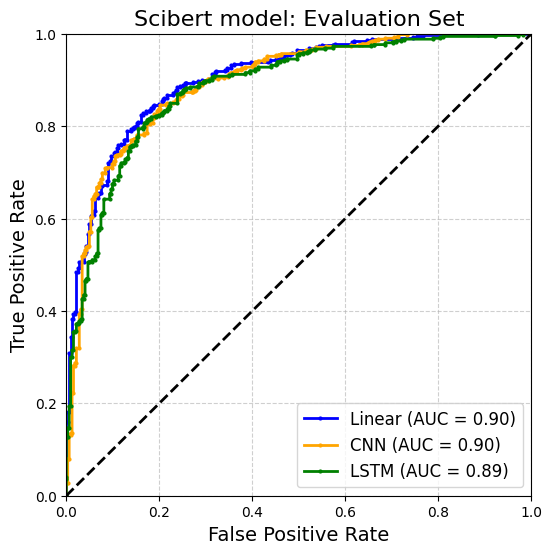

In [20]:

roc_aucs = [roc_auc1, roc_auc2, roc_auc3]
labels = ['Linear', 'CNN', 'LSTM']

plt.figure(figsize=(6, 6))  

plt.plot(fpr1, tpr1, lw=2, color='blue', label='{} (AUC = {:.2f})'.format('Linear', roc_auc1), marker='.', markersize=4)  
plt.plot(fpr2, tpr2, lw=2, color='orange', label='{} (AUC = {:.2f})'.format('CNN', roc_auc2), marker='.', markersize=4)  
plt.plot(fpr3, tpr3, lw=2, color='green', label='{} (AUC = {:.2f})'.format('LSTM', roc_auc3), marker='.', markersize=4)  

# Plot the diagonal line (random classifier) in black
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Scibert model: Evaluation Set', fontsize=16)

plt.legend(loc='lower right', fontsize=12)

# Set axis limits
plt.xlim([0, 1])
plt.ylim([0, 1])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Save or show the plot
plt.savefig(models_path + 'roc_curves_unbias.png', dpi=600, bbox_inches='tight')
plt.show()

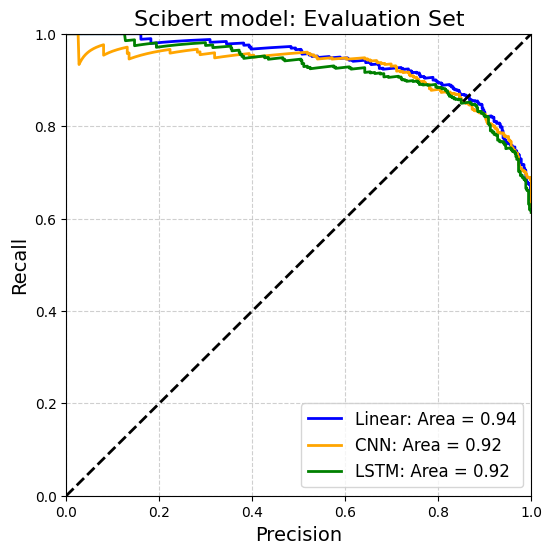

In [21]:
precisions = [precision1, precision2, precision3]
recalls = [recall1, recall2, recall3]
areas = [area1, area2, area3]

plt.figure(figsize=(6, 6))  

# Plot the precision-recall curves with the same colors and line styles as ROC curves
plt.plot(recall1, precision1, color='blue', label='Linear: Area = %0.2f' % area1, lw=2, markersize=4)
plt.plot(recall2, precision2, color='orange', label='CNN: Area = %0.2f' % area2, lw=2, markersize=4)
plt.plot(recall3, precision3, color='green', label='LSTM: Area = %0.2f' % area3, lw=2, markersize=4)

plt.legend(loc='lower right')

# Plot the diagonal line (random classifier) in black
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('Precision', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.title('Scibert model: Evaluation Set', fontsize=16)

plt.legend(loc='lower right', fontsize=12)

# Set axis limits
plt.xlim([0, 1])
plt.ylim([0, 1])

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Save or show the plot
plt.savefig(models_path + 'precision_recall_unbias.png', dpi=600, bbox_inches='tight')
plt.show()

In [22]:
# PLOT THE LOSSES

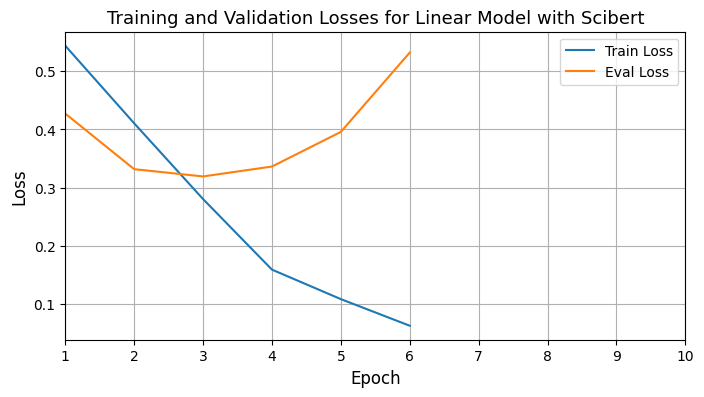

In [23]:
df = pd.read_csv(models_path + "/losses_linear_best_fold.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Eval Loss"], label="Eval Loss")

plt.xlim(1, 10)
plt.xticks(range(1, 11))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for Linear Model with Scibert", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/linear_plot.png", dpi=600)

plt.show()

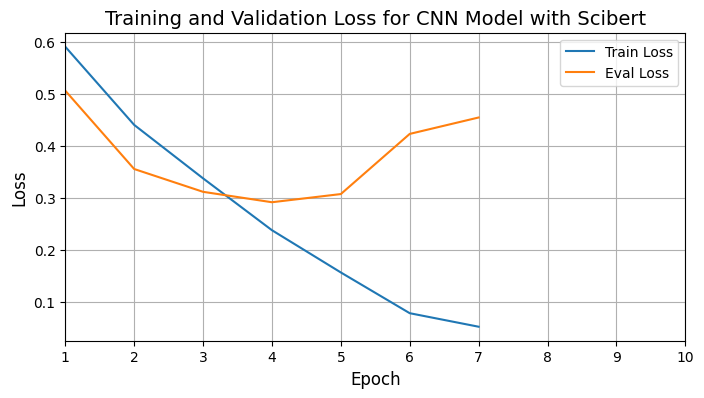

In [26]:
df = pd.read_csv(models_path + "/losses_cnn_best_fold.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Eval Loss"], label="Eval Loss")

plt.xlim(1, 10)
plt.xticks(range(1, 11))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Loss for CNN Model with Scibert", size=14)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/cnn_plot.png", dpi=600)

plt.show()

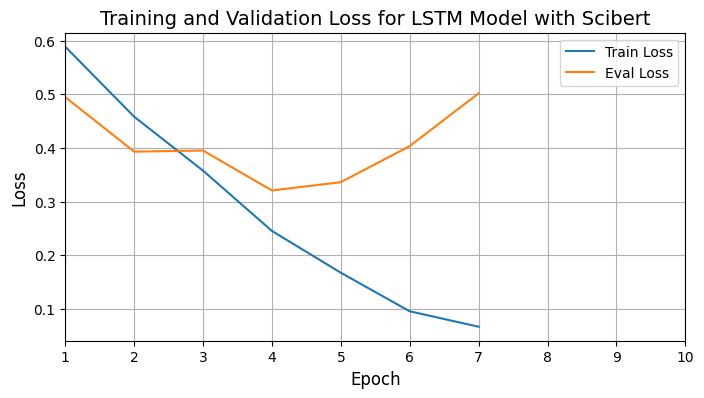

In [27]:
df = pd.read_csv(models_path + "/losses_lstm_best_fold.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Eval Loss"], label="Eval Loss")

plt.xlim(1, 10)
plt.xticks(range(1, 11))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Loss for LSTM Model with Scibert", size=14)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/lstm_plot.png", dpi=600)

plt.show()